In [276]:
import gpxpy
import pandas as pd
from geopy.distance import geodesic, Distance
import matplotlib.pyplot as plt
from zoneinfo import ZoneInfo
import colorcet as cc
import branca.colormap as cm
import numpy as np

gpx = gpxpy.parse(open('track.gpx'))

points = []
for track in gpx.tracks:
    for segment in track.segments:
        for p in segment.points:
            points.append({
                'time': p.time,
                'latitude': p.latitude,
                'longitude': p.longitude,
                #'elevation': p.elevation,
            })
df = pd.DataFrame.from_records(points)

df = df.sort_values('time').reset_index(drop=True)

df.time = df.time.dt.tz_convert(ZoneInfo('America/Chicago'))

df = df.set_index('time')

def shift_geodesic(r):
    return geodesic((r.latitude_1, r.longitude_1), (r.latitude_0, r.longitude_0))

df['ds'] = df[['latitude', 'longitude']].shift([0, 1]).bfill().apply(shift_geodesic, axis=1)
df['distance'] = df['ds'].cumsum()

df['dt'] = df.index.diff().fillna(pd.Timedelta(0))
df['duration'] = df['dt'].cumsum()

def speed(r):
    try:
        return r['ds'].nautical / (r['dt'].total_seconds() / 3600)
    except ZeroDivisionError:
        return 0

df['speed'] = df.apply(speed, axis=1)

df2 = df[['latitude', 'longitude', 'ds', 'dt']].resample("5min").agg({
        'latitude': 'first',
        'longitude': 'first',
        'ds': lambda x: x.sum(min_count=1),
        'dt': lambda x: x.sum(min_count=1),
    })
df2 = df2.dropna()

df2['speed'] = df2.apply(speed, axis=1)

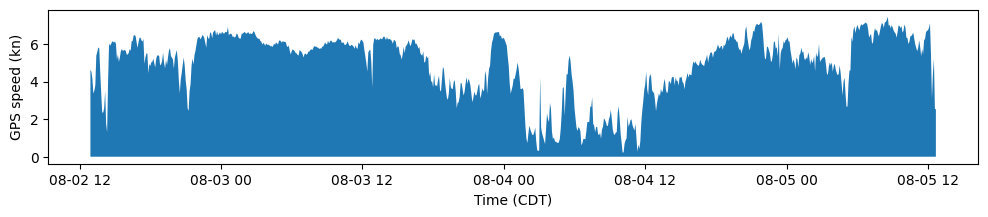

In [277]:
plt.figure(figsize=(12,2))
#df.speed.rolling('10min').mean().plot()
plt.fill_between(df2.index, df2.speed)
plt.xlabel('Time (CDT)')
plt.ylabel('GPS speed (kn)')
plt.savefig('test.png')
plt.show()

In [278]:
import folium

In [279]:
m = folium.Map(location=(47.54744813334115, -87.85940722672271), zoom_start=7)

In [280]:
cmap = cc.cm['rainbow4']
branca_cmap = cm.LinearColormap(
    colors=[cmap(i) for i in np.linspace(0, 1, 20)],
    vmin=0,
    vmax=7,
    caption='Speed (kn)'
)#.to_step(7)

In [281]:
color_line = folium.ColorLine(
    positions=list(zip(df2.latitude, df2.longitude)),
    colors=df2.speed,
    colormap=branca_cmap,
    weight=5,
).add_to(m)

In [282]:
m.add_child(branca_cmap);

In [283]:
folium.Marker(
    location=[46.5116666667, -84.615],
    tooltip="Start",
    popup="Start",
    icon=folium.Icon(icon="flag"),
).add_to(m);
folium.Marker(
    location=[46.7796666667, -92.0863333333],
    tooltip="Finish",
    #popup="",
    icon=folium.Icon(icon="flag"),
).add_to(m);


In [284]:
m

In [285]:
m.save("index.html")

In [ ]:
m.